# Model

In [1]:
%load_ext autoreload
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
enable_float64 = False
from jax.config import config
config.update("jax_enable_x64", enable_float64)
# config.update("jax_log_compiles", True)
# config.update('jax_disable_jit', True)
config.update("jax_debug_nans", True)
import json_tricks as json
import copy
from tqdm import tqdm
from cycler import cycler

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import models
import svgd

from jax.experimental import optimizers

key = random.PRNGKey(0)
colors = iter(['r', 'g', 'b', 'y'])

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [36]:
# target = distributions.Gaussian(0, .1)
# proposal = distributions.Gaussian(0, 5)
setup = distributions.funnel
target, proposal = setup.get()

n_particles = 400
n_iter = 15
n_iter_kernel = 20
svgd_lr = 0.1
kernel_lr = 0.1
sizes = [1]

key, subkey, svgd_key = random.split(key, 3)
# key, subkey, svgd_key = random.split(key, 3)
# key, subkey, svgd_key = random.split(key, 3)
learner = svgd.AdversarialSVGD(subkey,
                               target,
                               proposal,
                               sizes,
                               n_particles=n_particles,
                               svgd_lr=svgd_lr,
                               kernel_lr=kernel_lr,
                               svgd_key=svgd_key)

In [37]:
def makeplots(svgd, kernel_learner=None, sep_groups=False):
    fig, axs = plt.subplots(2, 2, figsize=[18, 10])
    n_steps = svgd.step_counter
    stepgrid = np.arange(n_steps)
    
    axs = axs.flatten()
    ax=axs[0]
    colors = iter(['b', 'orange', 'r', 'g', 'y'])

    if sep_groups:
        for idx, name in zip(svgd.group_idx, [gn + " Histogram" for gn in ("Leader", "Follower")]):
            color=next(colors)
            ax.hist(svgd.get_params()[idx, 0], density=True, bins=25, label=name, alpha=0.5, color=color)
            ax.plot(svgd.get_params()[idx], np.exp(svgd.loglikelihood)[idx], ".", label="Likelihood", color=color)
    else:
        ax.hist(svgd.get_params()[:, 0], density=True, bins=25)
    plot.plot_fun(svgd.target.pdf, lims=ax.get_xlim(), ax=ax, label="Target")
    
    ax=axs[1]
    if sep_groups:
        ax.plot(stepgrid, svgd.rundata["leader_std"],   "--o", label="Leader Stddev")
        ax.plot(svgd.rundata["follower_std"], "--o", label="Follower Stddev")
    else:
        ax.plot(svgd.rundata["leader_std"], "--o", label="Leader Stddev")

    ax.set_xlabel("Step")
    
    if kernel_learner is not None:
        ax.plot(np.linspace(0, n_steps, n_steps*n_iter_kernel), kernel_learner.rundata["bandwidth"], label="bandwidth")    
    
    ax=axs[2]
    ax.plot(stepgrid[:-1], -onp.diff(svgd.rundata["leader_kl"]), "--o", label="KL diff")
    ax.plot(stepgrid, np.array(svgd.rundata["leader_ksd"]) * svgd_lr, "--o", label="KSD^2 * stepsize")
    ax.set_yscale("log")
        
    if kernel_learner is not None:
        ax=axs[3]
        ax.plot(kernel_learner.rundata["loss"], label="Loss")
#         ax.set_yscale("log")

    for ax in axs: 
        ax.legend()

In [38]:
def comparison_plot(svgds, names):
    """svgds: list of svgd objects"""
    fig, axs = plt.subplots(1, 3, figsize=[23, 7])
    assert all([svgd.step_counter == svgds[0].step_counter for svgd in svgds])
    stepgrid = np.arange(svgds[0].step_counter)
    colors = iter(['r', 'g', 'b', 'y'])
    
    for svgd, name, color in zip(svgds, names, colors):
        axsiter = iter(axs.flatten())

        ax = next(axsiter)
        ax.plot(stepgrid[:-1], -onp.diff(svgd.rundata["leader_kl"]), "--o", label=f"{name} KL diff", color=color)
        ax.plot(stepgrid, np.array(svgd.rundata["leader_ksd"]) * svgd_lr, "--.", label=f"{name} KSD^2 * stepsize", color=color)
        ax.set_yscale("log")
        
        ax = next(axsiter)
        ax.plot(svgd.rundata["leader_std"], "--o", label=f"{name} Leader Stddev", color=color)
        
        ax = next(axsiter)
        ax.plot(svgd.rundata["leader_mean"], "--o", label=f"{name} Leader Mean", color=color)

    for ax in axs.flatten(): 
        ax.legend()
        ax.set_xlabel("Step")


# Run experiments

In [39]:
names = ["Trained", "Fixed"]

#### Learned kernel

In [40]:
learner.flow_and_train(n_iter=n_iter, n_iter_kernel=n_iter_kernel)

100%|██████████| 15/15 [00:15<00:00,  1.05s/it]


#### Fixed kernel

In [41]:
# key, subkey = random.split(key)

s = svgd.SVGD(
    svgd_key, target, proposal, n_particles, learning_rate=svgd_lr,
    get_kernel=lambda par: kernels.get_rbf_kernel(1.)
)

In [42]:
s.flow(n_iter=n_iter)

100%|██████████| 15/15 [00:07<00:00,  1.89it/s]


#### Adaptive kernel

In [43]:
# # key, subkey = random.split(key)
# s2 = kernel_learning.SVGD(svgd_key, target, proposal, n_particles, learning_rate=svgd_lr, get_kernel=kernels.get_rbf_kernel)

# h = 1
# for _ in tqdm(range(n_iter)):
#     s2.step(h)
#     particles = s2.get_params()
#     h = np.var(particles)

# Comparison

In [44]:
print("Trained bandwidth: KL =", learner.svgd.rundata["leader_kl"][-1])
print("Fixed bandwidth: KL =", s.rundata["leader_kl"][-1])
# print("Adaptive b=var:", s2.rundata["KL"][-1])

Trained bandwidth: KL = 2.6572838
Fixed bandwidth: KL = 3.0677042


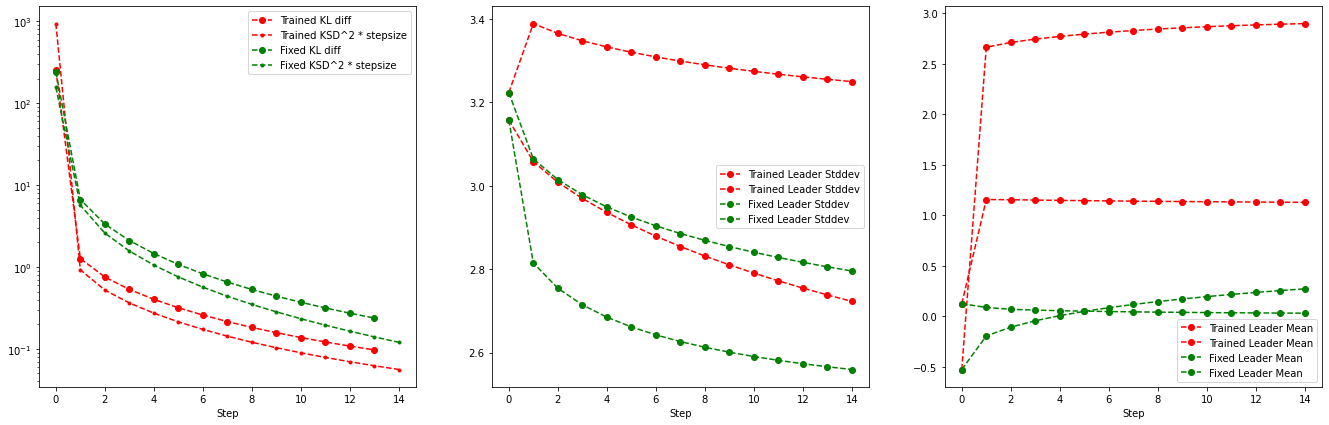

In [45]:
comparison_plot((learner.svgd, s), names)

Text(0.5, 1.0, 'KL Divergence')

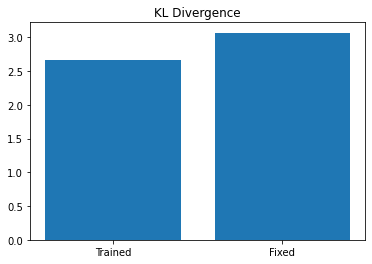

In [46]:
scores = [svgd.rundata["leader_kl"][-1] for svgd in (learner.svgd, s)]
plt.bar(np.arange(len(scores)), scores, tick_label=names)
plt.title("KL Divergence")

# plots of individual runs

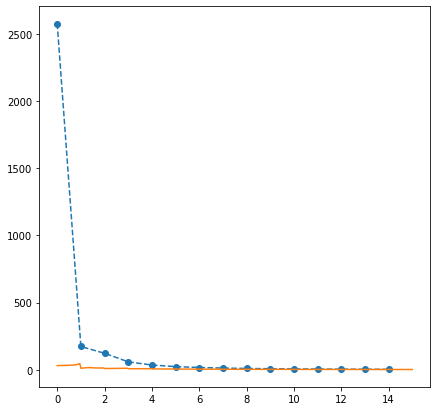

In [34]:
steps = learner.svgd.step_counter
grid      = np.arange(steps)
densegrid = np.linspace(0, steps, num=steps*n_iter_kernel)
fig, axs = plt.subplots(figsize=[7,7])
plt.plot(grid, learner.svgd.rundata["leader_ksd"], "--o")
plt.plot(densegrid, np.asarray(learner.kernel.rundata["training_ksd"]))

ValueError: x needs to have shape (2,). Instead, received x of shape ().

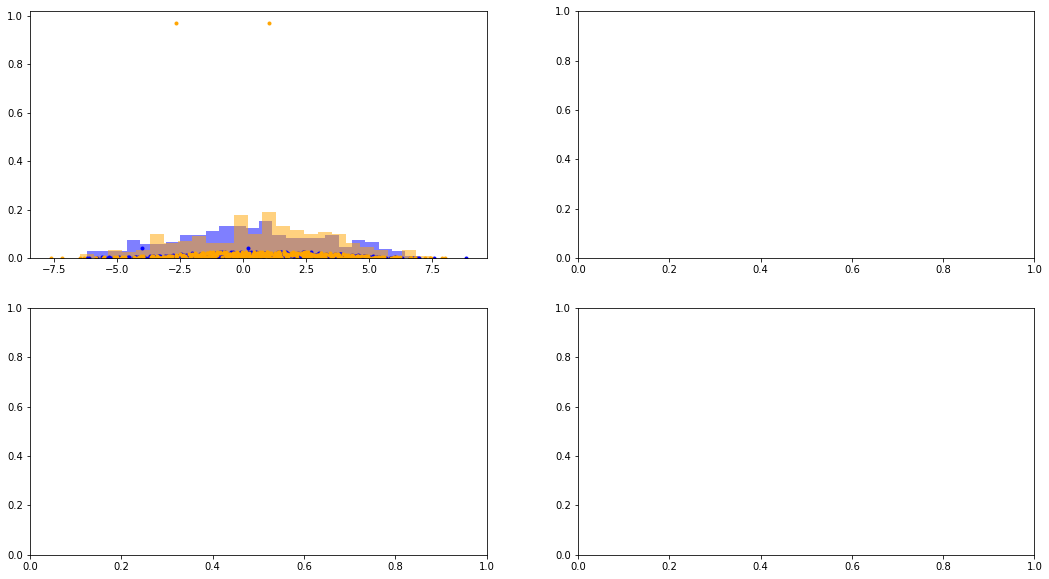

In [35]:
makeplots(learner.svgd, learner.kernel, sep_groups=True)
makeplots(s)
# makeplots(s2)

# Plot the kernel

In [ ]:
params = learner.kernel.get_params()
learned_kernel = learner.kernel.get_kernel(params)
# learned_kernel = s.get_kernel(None) # RBF for comparison
samples = proposal.sample(100)
learned_kernel(samples[4], samples[10])

In [ ]:
if proposal.d == 1:
    ngrid = 10**4
    grid = np.linspace(-15, 10, ngrid).reshape(ngrid,1)
    xgrid = np.arange(-2, 2).reshape((4, 1))
    xgrid = np.array([[-4], [2], [4]])
    for x in xgrid:
        plt.plot(grid, vmap(learned_kernel, (0, None))(grid, x), label="Learned")
    #     plt.plot(grid, vmap(kernels.get_rbf_kernel(1),  (0, None))(grid, x), label="RBF", color="b")
    plt.legend()
elif proposal.d == 2:
    fig, ax = plt.subplots(figsize=[7,7])
    x = np.array([0, 0])
    def kernfunx(x_): return learned_kernel(x, x_)
#     def rbfx(x_): return kernels.get_rbf_kernel(1)(x, x_)
    plot.plot_pdf_2d(kernfunx, lims=(-10, 10), label="Learned Kernel", ax=ax)
#     plot.plot_pdf_2d(rbfx, lims=(-10, 10), label="RBF", ax=ax)